# Formula 1 Pit Stop Analysis

## Intro?

## Setup

Ergast database has been converted to SQLite and PHP source code has been translated to Python. Upon executing we need to ensure that the working dir is the parent folder, otherwise paths won't work. This is only an issue when running in the notebook, regular python interpreter uses the correct paths from venv.

In [18]:
import os
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# NOTE: We have to prepare notebook to work with our existing folder structure
if os.getcwd().count("asipf1") > 1:
    os.chdir("..")

import ergast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np


sns.set_theme(
    "notebook", "darkgrid", rc={"axes.grid": True, "figure.figsize": (20, 5)}
)


### Collecting data
Pit stop data is unfortunately only available from 2012 season onwards. There is data from 1994 harvested from formula1.com but unfortunately it has missing pit stop entries and some of them are extremely wrong (i.e. 2008 German Grand Prix has missing entries for the first pit stop, therefore marking Hamiltons second stop on Lap 50 as first stop etc.).

In [19]:
# Collecting data
max_season = ergast.season_list()["year"].max()
print(f"Collecting results and pit stop data from 2012 till {max_season}")

results = ergast.race_results().query("year >= 2012")
stops = pd.DataFrame([])

for year in range(2012, max_season + 1):
    race_count = len(ergast.race_schedule(year=year).index)
    for race in range(1, race_count + 1):  # Rounds are 1-index based
        stops = pd.concat([stops, ergast.pit_stops(year, race)])

stops["pitstopDuration"] = stops["durationMilliseconds"] / 1000
        

In [20]:
results.head()

,year,round,raceName,date,time,url,circuitId,circuitName,locality,country,...,familyName,dateOfBirth,nationality,driverUrl,statusId,status,constructorId,constructorName,constructorNationality,constructorUrl
21235,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,...,Button,1980-01-19,British,http://en.wikipedia.org/wiki/Jenson_Button,1,Finished,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
21236,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,...,Vettel,1987-07-03,German,http://en.wikipedia.org/wiki/Sebastian_Vettel,1,Finished,red_bull,Red Bull,Austrian,http://en.wikipedia.org/wiki/Red_Bull_Racing
21237,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,...,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton,1,Finished,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
21238,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,...,Webber,1976-08-27,Australian,http://en.wikipedia.org/wiki/Mark_Webber_(raci...,1,Finished,red_bull,Red Bull,Austrian,http://en.wikipedia.org/wiki/Red_Bull_Racing
21239,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,...,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso,1,Finished,ferrari,Ferrari,Italian,http://en.wikipedia.org/wiki/Scuderia_Ferrari


In [21]:
stops.head()

,year,round,raceName,date,time,url,circuitId,circuitName,locality,country,circuitUrl,lat,long,altitude,driverId,pitstop,lap,localTime,pitstopDuration,durationMilliseconds
0,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,-37.8497,144.968,10,bruno_senna,1,1,17:05:23,24.599,24599
1,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,-37.8497,144.968,10,ricciardo,1,1,17:05:35,32.319,32319
2,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,-37.8497,144.968,10,massa,1,11,17:21:08,22.313,22313
3,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,-37.8497,144.968,10,rosberg,1,12,17:22:31,23.203,23203
4,2012,1,Australian Grand Prix,2012-03-18,06:00:00,http://en.wikipedia.org/wiki/2012_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,http://en.wikipedia.org/wiki/Melbourne_Grand_P...,-37.8497,144.968,10,alonso,1,13,17:24:04,22.035,22035


## Pit Stop duration analysis
### Did pit stop duration change over years?

Text(0.5, 1.0, 'Pit Stop Durations per year')

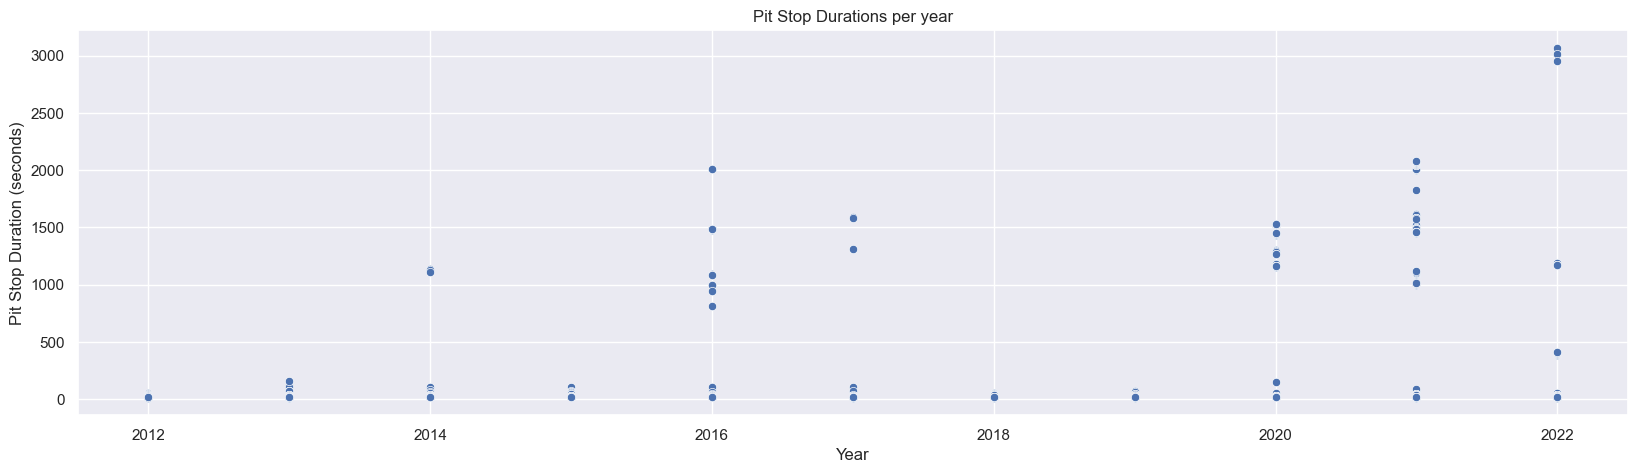

In [22]:
sns.scatterplot(
    stops,
    x="year",
    y="pitstopDuration",
)
plt.xlabel("Year")
plt.ylabel("Pit Stop Duration (seconds)")
plt.title("Pit Stop Durations per year")


We can immediately notice that the large number of outliers skew the results. These outliers correlate with the Red Flagged sessions. Unfortunately Ergast does not contain any kind of data to indicate red-flagged sessions, therefore we will repeat with cut-off of 5 minutes (300seconds).

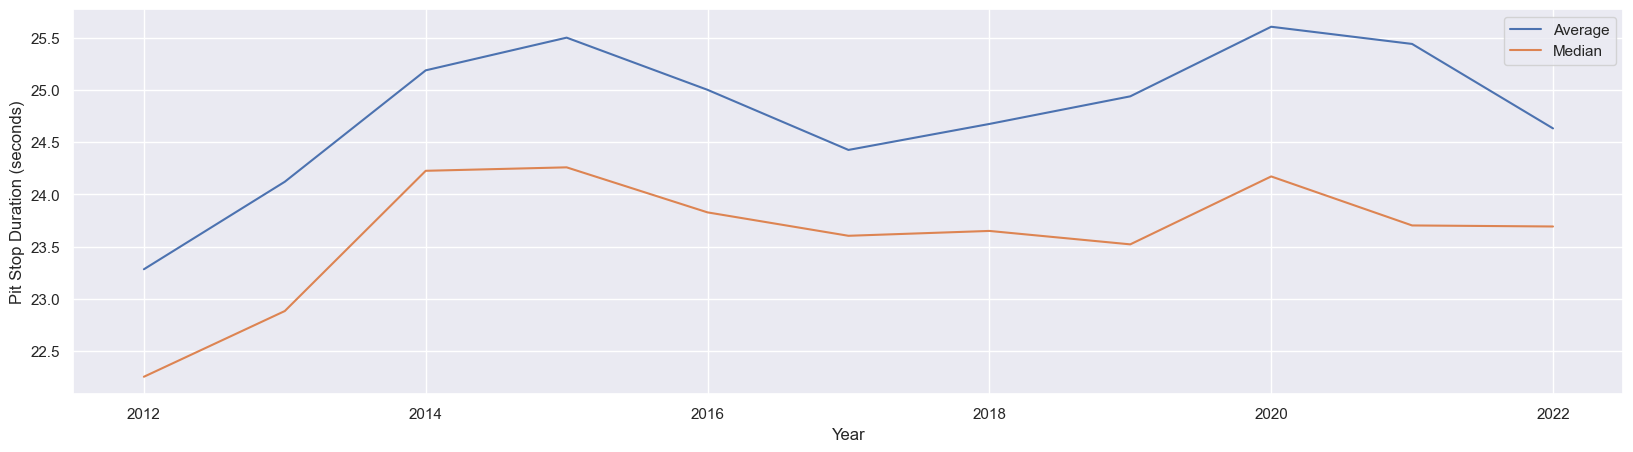

In [23]:
stops_filtered = stops[stops["pitstopDuration"] < 300]

fig = px.scatter(
    stops_filtered,
    x="year",
    y="pitstopDuration",
    color="circuitName",
    title="Pit Stop Durations per year",
    hover_data=["driverId"],
)
fig.show()

grouped = stops_filtered.groupby(["year"])
year_avgs = pd.DataFrame()
for name, group in grouped:
    item = pd.DataFrame(
        {
            "year": [name],
            "averageDuration": group["pitstopDuration"].mean(),
            "medianDuration": group["pitstopDuration"].median(),
        }
    )
    year_avgs = pd.concat([year_avgs, item])
year_avgs.reset_index(inplace=True, drop=True)

sns.lineplot(data=year_avgs, x="year", y="averageDuration", label="Average")
sns.lineplot(data=year_avgs, x="year", y="medianDuration", label="Median")
plt.xlabel("Year")
plt.ylabel("Pit Stop Duration (seconds)")

del grouped, fig


It is noticeable that both the average and median pit stop duration has risen by about a second since the introduction of the Turbo Hybrid V6 cars in the 2014. It is relatively stable since then. However this does not take into account the pit entry length etc. and could just be due to the different tracks in the given calendar year. Therefore we should check how much each circuit affects the pit stop duration.

### Does track influence the pitstop duration?

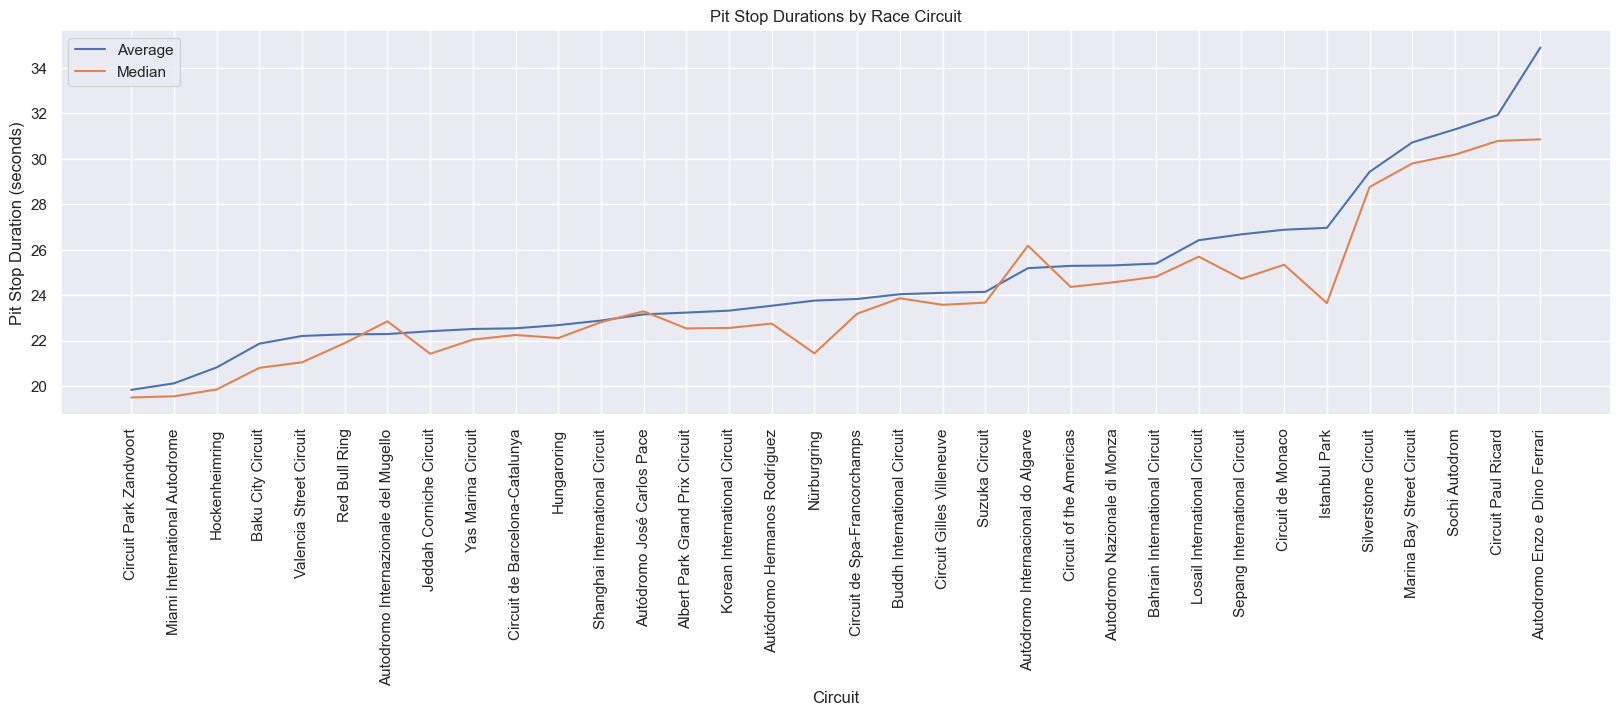

In [24]:
fig = px.box(
    stops_filtered,
    x="circuitName",
    y="pitstopDuration",
    color="circuitName",
    title="Pit Stop Durations by Race Circuit",
)
fig.show()

grouped = stops_filtered.groupby(["circuitId"])
circuit_avgs = pd.DataFrame()
for name, group in grouped:
    item = pd.DataFrame(
        {
            "circuitId": name,
            "circuitName": group["circuitName"],
            "averageDuration": group["pitstopDuration"].mean(),
            "medianDuration": group["pitstopDuration"].median(),
        }
    )
    circuit_avgs = pd.concat([circuit_avgs, item])
circuit_avgs.drop_duplicates("circuitId", inplace=True)
circuit_avgs.sort_values(by="averageDuration", inplace=True)
circuit_avgs.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()
sns.lineplot(
    data=circuit_avgs, x="circuitId", y="averageDuration", label="Average", ax=ax
)
sns.lineplot(
    data=circuit_avgs, x="circuitId", y="medianDuration", label="Median", ax=ax
)
ax.set_title("Pit Stop Durations by Race Circuit")
ax.set_xlabel("Circuit")
ax.set_ylabel("Pit Stop Duration (seconds)")
ax.set_xticks(ax.get_xticks(), circuit_avgs["circuitName"], rotation=90)

del grouped, fig

Correlation between averages: 0.80
Correlation between means: 0.06


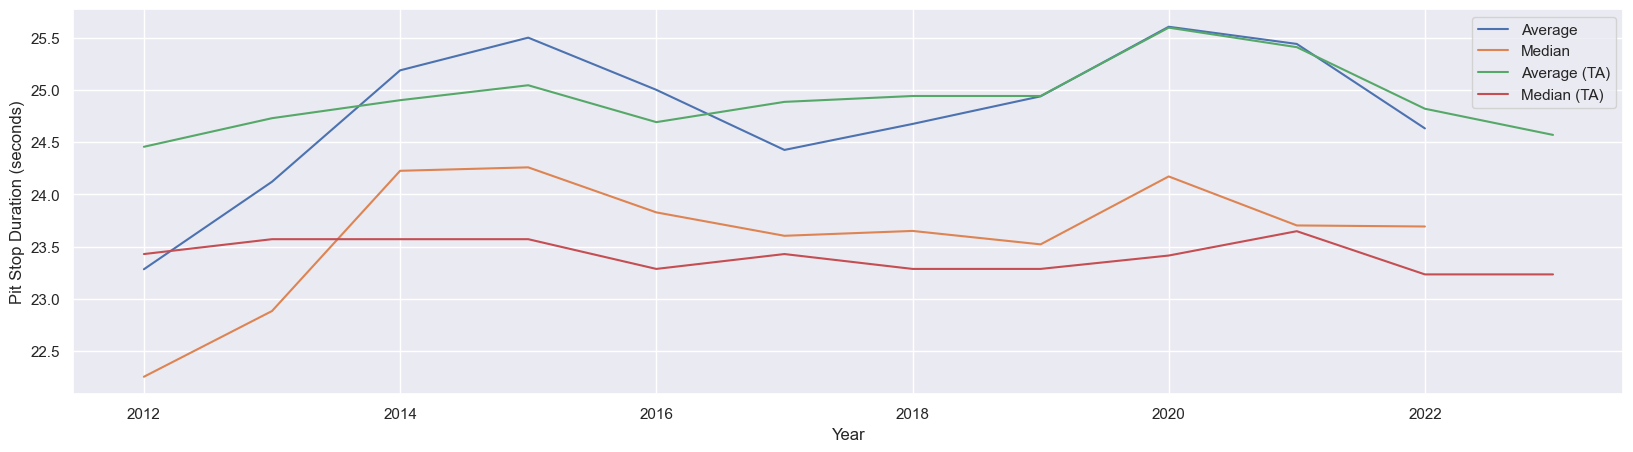

In [33]:
races = ergast.race_schedule().query("year >= 2012")[["year", "round", "circuitId"]]
grouped = races.groupby(["year"])
circuitids_per_year = grouped["circuitId"].apply(list)

new_year_avgs = pd.DataFrame()
for year, circuitids in circuitids_per_year.iteritems():
    circuit_avgs_year = circuit_avgs[circuit_avgs["circuitId"].isin(circuitids)]
    item = pd.DataFrame(
        {
            "year": [year],
            "averageDuration": circuit_avgs_year["averageDuration"].mean(),
            "medianDuration": circuit_avgs_year["medianDuration"].median(),
        }
    )
    new_year_avgs = pd.concat([new_year_avgs, item])
new_year_avgs.reset_index(inplace=True, drop=True)

sns.lineplot(data=year_avgs, x="year", y="averageDuration", label="Average")
sns.lineplot(data=year_avgs, x="year", y="medianDuration", label="Median")
sns.lineplot(data=new_year_avgs, x="year", y="averageDuration", label="Average (TA)")
sns.lineplot(data=new_year_avgs, x="year", y="medianDuration", label="Median (TA)")
plt.xlabel("Year")
plt.ylabel("Pit Stop Duration (seconds)")

print(
    "Correlation between averages:",
    f'{year_avgs["averageDuration"].corr(new_year_avgs["averageDuration"]):.2f}',
)
print(
    "Correlation between means:",
    f'{year_avgs["medianDuration"].corr(new_year_avgs["medianDuration"]):.2f}',
)
